# Source Code: BIG Data = Big Bias? An Analysis of Google Search Suggestions

## HID104, HID216; Gabriel Jones and Matt Millard

### Dataset: Names_2010Census.csv
https://www.census.gov/topics/population/genealogy/data/2010_surnames.html

## Data Preparation

### Step 1: Import modules 
Make sure that all of the necessary modules have been installed with pip.

Some of visualizations will use custom imports later.

In [1]:
import requests, json, csv, urllib.request
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi
from scipy import stats
from timeit import default_timer as timer

### Step 2: Download and Read CSV Data from Github and group into races
We take the data from the raw content url on github.

We download the data and write it as a file to the Desktop.

In [2]:
resource = urllib.request.urlopen("https://raw.githubusercontent.com/bigdata-i523/hid104/master/project/projectdata.csv")
out = open("projectdata.csv","wb")
out.write(resource.read())
out.close()

Now that we have our file created on the desktop, we can read it with dictreader.

We also create a list and a dictionary which will be used to store the name data later.

In [3]:
file = open("projectdata.csv", "r")
name_csv = csv.DictReader(file)

name_lst = [] #This list will be used later
name_race = {'pctwhite':'', 'pctblack':'', 'pctapi':'', 'pcthispanic':''} #Based on the header names in the csv.DictReader

#### Now that we have read in the file, we use for loops to store the first 500 names as strings in their appropriate categories
For the scope of our analysis, we chose to analyze the first 500 names. The file contains a total of 162,253 unique names.

The name is considered part of the category with which their name most likely belongs, based on the percentage of people that identify with that racial/ethnic category. For instance, since 70.9% of people with the surname 'Smith' identify as white, Smith is considered a white name in the analysis.

People that identify as native American or Multiracial are not included because none of the 500 names are primarily associated with these groups.

In [4]:
for index, row in enumerate(name_csv):
    if index >= 500:  #This looks at only the first 501 rows, which include the first 500 surnames.
        break
    name_lst.append(row['name'])
    if max(row['pctwhite'], row['pctblack'], row['pctapi'], row['pctaian'], row['pct2prace'], row['pcthispanic']) == row['pctwhite']:
        name_race['pctwhite']+=row['name']
        name_race['pctwhite']+= ' '
    elif max(row['pctwhite'], row['pctblack'], row['pctapi'], row['pctaian'], row['pct2prace'], row['pcthispanic']) == row['pctblack']:
        name_race['pctblack']+=row['name']
        name_race['pctblack']+= ' '
    elif max(row['pctwhite'], row['pctblack'], row['pctapi'], row['pctaian'], row['pct2prace'], row['pcthispanic']) == row['pctapi']:
        name_race['pctapi']+=row['name']
        name_race['pctapi']+= ' '
    elif max(row['pctwhite'], row['pctblack'], row['pctapi'], row['pctaian'], row['pct2prace'], row['pcthispanic']) == row['pcthispanic']:
        name_race['pcthispanic']+=row['name']
        name_race['pcthispanic']+= ' '

file.close() #Now that we are finished accessing the csv file, we can close it.

#### Now that the surnames are sorted by category, we split the string so that each category has a list of names
We also create an indexed dictionary of the names for later reference

We also count the number of names for each category

In [5]:
names = {k: v + 1 for v, k in enumerate(name_lst)}

name_race['pctwhite'] = name_race['pctwhite'].split()
name_race['pctblack'] = name_race['pctblack'].split()
name_race['pctapi'] = name_race['pctapi'].split()
name_race['pcthispanic'] = name_race['pcthispanic'].split()

name_counts = [len(name_race['pctwhite']), len(name_race['pctblack']), len(name_race['pctapi']), len(name_race['pcthispanic'])]

### Step 3: Define function to capture search suggetion results

The function stores the 10 search suggestions for whichever key word is passed to it. It tracks how many times key word searches match the target search word

In [6]:
#Define user agent set to Mozilla Firefox
headers = {'User-agent':'Mozilla/5.0'}

#Create a function to iterate through names and capture search results
def suggestion_master(results, dictionary, search, target, target2 = None):
    for name in names.keys():
        URL="http://suggestqueries.google.com/complete/search?client=firefox&q=" + name + " " + target
        response = requests.get(URL, headers=headers)
        results.append(json.loads(response.content.decode('utf-8')))    #captures search results and appends to a list
    for result in results:  #iterates through search results for every name
        name = result[0].split()
        for suggestion in result[1]:
            if target or target2 in suggestion:
                dictionary[name[0]] += 1

### Step 4 Run the test for search result case

We run the function five times for each criterion we are interested in. This section takes around 200 seconds when run on our local machine, and we include a timer to test for efficiency

The dictionary comprehensions and results lists store the data for later analysis

In [7]:
#Tracks how long it takes to run the functions
start = timer()

#4a
arrest_results = []
arrest_dict = {k: v*0 for v, k in enumerate(name_lst)}
suggestion_master(arrest_results, arrest_dict, "arre", "arrest")

#4b
murder_results = []
murder_dict = {k: v*0 for v, k in enumerate(name_lst)}
suggestion_master(murder_results, murder_dict, "murd", "murder")

#4c
homicide_results = []
homicide_dict = {k: v*0 for v, k in enumerate(name_lst)}
suggestion_master(homicide_results, homicide_dict, "homi", "homicide")

#4d
crime_results = []
crime_dict = {k: v*0 for v, k in enumerate(name_lst)}
suggestion_master(crime_results, crime_dict, "crim", "crime", "criminal")

#4e
prison_results = []
prison_dict = {k: v*0 for v, k in enumerate(name_lst)}
suggestion_master(prison_results, prison_dict, "pris", "prison")

#Tracks how long it takes to run the functions
end = timer()
query_time = (end - start)

### Step 5 Summarise data results
In this section, we prepare all of the data which will allow us to create visualizations.

We start by creating a list of the dictionaries containing the search results for each search criterion.

In [44]:
avg_data = [arrest_dict, murder_dict, homicide_dict, crime_dict, prison_dict]

#### 5a Calculate search data results by race/ethnicity category
We now summarize the search result data according to each racial/ethnic category for each search criterion.

First, we create dictionaries for each racial/ethnic category and for each search criterion.

In each case, one of the dictionaries will contain the raw data for later statistical analysis, and the other will just be used for the averages.

In [45]:
pctwhite_stats = {'arrest':[], 'murder':[], 'homicide':[],'crime':[],'prison':[]}
pctwhite_avg = {'arrest':[], 'murder':[], 'homicide':[],'crime':[],'prison':[]}

pctblack_stats = {'arrest':[], 'murder':[], 'homicide':[],'crime':[],'prison':[]}
pctblack_avg = {'arrest':[], 'murder':[], 'homicide':[],'crime':[],'prison':[]}

pctapi_stats = {'arrest':[], 'murder':[], 'homicide':[],'crime':[],'prison':[]}
pctapi_avg = {'arrest':[], 'murder':[], 'homicide':[],'crime':[],'prison':[]}

pcthispanic_stats = {'arrest':[], 'murder':[], 'homicide':[],'crime':[],'prison':[]}
pcthispanic_avg = {'arrest':[], 'murder':[], 'homicide':[],'crime':[],'prison':[]}

We group the terms and the stats dictionaries into lists for simplified indexing.

In [46]:
stats_lst = [pctwhite_stats, pctblack_stats, pctapi_stats, pcthispanic_stats]
term_lst = ['arrest','murder','homicide','crime','prison']

The following function fills each of the dictionaries with the appropriate data. We run it once for each category

In [47]:
#Define a function to calculate results for every race/ethnicity and for every search criterion
def stat_stuffer(race_name, pct_stats, avg_list):
    for i in range(0, len(avg_list)):
        for datum in avg_list[i]:
            for name in name_race[race_name]:
                if datum == name:
                    pct_stats[term_lst[i]].append(avg_list[i][datum])

                    
                    
#Run the function for every race/ethnicity for both the stats dictionaries and the average dictionaries
stat_stuffer('pctwhite', pctwhite_stats, avg_data)
stat_stuffer('pctwhite', pctwhite_avg, avg_data)

stat_stuffer('pctblack', pctblack_stats, avg_data)
stat_stuffer('pctblack', pctblack_avg, avg_data)

stat_stuffer('pctapi', pctapi_stats, avg_data)
stat_stuffer('pctapi', pctapi_avg, avg_data)

stat_stuffer('pcthispanic', pcthispanic_stats, avg_data)
stat_stuffer('pcthispanic', pcthispanic_avg, avg_data) 

### 5b Average all the results
In this section we average the results for each category and each criterion

First we create a dictionary for the data

In [48]:
#One dictionary stores just raw data which will be used to create a box plot and to write to csv
name_race_raw = {'pctwhite':[], 'pctblack':[], 'pctapi':[], 'pcthispanic':[]}
name_race_avg = {'pctwhite':0, 'pctblack':0, 'pctapi':0, 'pcthispanic':0}

We now use a series of for loops to populate the data

In [49]:
for race_name in name_race: #Iterates through each racial category
    for data in avg_data: #Iterates through each criterion results dictionary
        for datum in data: #Iterates through each name in each results dictionary
                for name in name_race[race_name]: #Iterates through each name for each racial category
                    if datum == name: #Compares the name in the results dictionary to the name in the racial category
                        name_race_raw[race_name].append(data[datum]) #If the name matches, it adds its score
                        name_race_avg[race_name]+=data[datum]

Now that we have the aggregate data stored, we take the averages for each race/ethnicity and for all the names regardless of category

In [50]:
#Calculate average aggregate associations for every race/ethnicity
for race_avg in name_race_avg:
    name_race_avg[race_avg] = name_race_avg[race_avg] / len(name_race_raw[race_avg])

#Calculate average associations for every race/ethnicity by search criteria
for avg in pctwhite_avg:
    pctwhite_avg[avg] = sum(pctwhite_avg[avg]) / name_counts[0]

for avg in pctblack_avg:
    pctblack_avg[avg] = sum(pctblack_avg[avg]) / name_counts[1]

for avg in pctapi_avg:
    pctapi_avg[avg] = sum(pctapi_avg[avg]) / name_counts[2]

for avg in pcthispanic_avg:
    pcthispanic_avg[avg] = sum(pcthispanic_avg[avg]) / name_counts[3]

### 6 Statistical analysis from CSV file
In this section, we will write all the results to a .csv file and then conduct t tests to compare statistical significance.

#### 6 Write the results to a csv file
Writing the results to a csv file allows for more simplified interactivity and statistical analysis.

First, we write out the column headings.

In [51]:
csv_data = open("resultsdata.csv", "w")
columnTitleRow = "race,arrest,murder,homicide,crime,prison,total,average\n"
csv_data.write(columnTitleRow)

55

Now we write out the stats for each name with a number that corresponds to its race.

Unfortunately, writing to csv may return a number for each row written. This number should be ignored.

In [52]:
row = ""

for i in range(0, len(stats_lst)):
    race = i
    dict_values = [] #We create a list to store the values so that we can index them
    for value in stats_lst[i].values():
        dict_values.append(value)
    for j in range(0, len(dict_values[0])):
        sum_lst = []
        row += str(i) + ","
        for k in range(len(dict_values)):
            row += str(dict_values[k][j]) + ","
            sum_lst.append(dict_values[k][j])
        row += str(sum(sum_lst)) + ","
        row += str(sum(sum_lst)/len(sum_lst)) + "\n"

csv_data.write(row)

csv_data.close()

#### 6b Run 2-sample t-tests to compare calculate p values
First, we open the csv file we just created in DictReader mode

In [53]:
#Open the resultsdata with csv.DictReader
results_file = open("resultsdata.csv")
results_data = csv.DictReader(results_file)

We now define a series of empty lists that we can append the values to for our statistical analysis

In [54]:
#Define empty lists for each race
white_stats = []
black_stats = []
api_stats = []
hispanic_stats = []

We run a series of for loops to fill the lists with the data in the totals row and then close the file.

In [55]:
#Use if logic to sort the total row by race
for row in results_data:
    if row["race"] == "0":
        white_stats.append(row["total"])
    elif row["race"] == "1":
        black_stats.append(row["total"])
    elif row["race"] == "2":
        api_stats.append(row["total"])
    else:
        hispanic_stats.append(row["total"])


results_file.close()

We now cast the lists we just made as numpy arrays with float values.

We then run a two-sample t-test to compare all of the data to itself.

In [56]:
#Cast all the values as arrays with floats
black_stats = np.array(black_stats).astype(np.float)
white_stats = np.array(white_stats).astype(np.float)
api_stats = np.array(api_stats).astype(np.float)
hispanic_stats = np.array(hispanic_stats).astype(np.float)


#Run the 2-sample t-test to compare each data sample
stats.ttest_ind(white_stats, black_stats)
stats.ttest_ind(white_stats, api_stats)
stats.ttest_ind(white_stats, hispanic_stats)
stats.ttest_ind(black_stats, api_stats)
stats.ttest_ind(black_stats, hispanic_stats)
stats.ttest_ind(api_stats, hispanic_stats) 

Ttest_indResult(statistic=2.7166608777111749, pvalue=0.0075069468535116915)

## Data Visualization

### Step 7 Create Bar Chart Visualization
We will start by summarizing aggregate data with a bar chart in figure 1. This barchart will display the average number of negative word associations by racial/ethnic category.

We do another import statement here instead of at the begining to ensure that the import does not interfere with any of the other code.

In [57]:
import matplotlib.pyplot as plt; plt.rcdefaults()

We now set up the data with headers corresponding to the appropriate categories. We also create labels here.

In [58]:
#Set up categories and data 
objects = ('White ('+str(name_counts[0]) + ')', 'Black ('+str(name_counts[1]) + ')', 'Asian/Pacific ('+str(name_counts[2]) + ') ', 'Hispanic/Latino ('+str(name_counts[3]) + ')')
y_pos = np.arange(len(objects))
performance = [name_race_avg['pctwhite'],name_race_avg['pctblack'],name_race_avg['pctapi'],name_race_avg['pcthispanic']]

#Plot data
plt.bar(y_pos, performance, align='center', alpha=2)
plt.xticks(y_pos, objects)
plt.ylabel('Avg Association')
plt.title('Nevative Word Associations by Race/Ethnicity')

Now we plot the figure and save it. The figure saves as 'fig1' in the user folder.

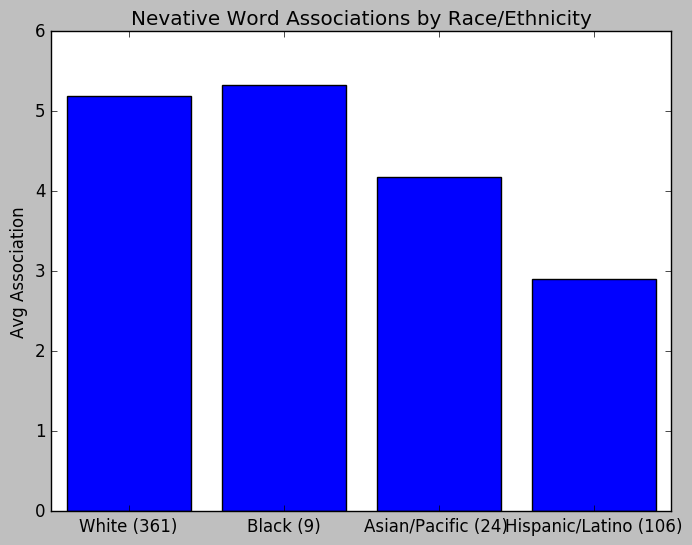

In [59]:
fig1 = plt.figure(1, figsize=(9, 6))
fig1.savefig('fig1.png', bbox_inches='tight')
plt.show()

### Step 7 Create Box Plot Visualizations
We will now summarise the same data in box plot form to give a clearer perspective into how the data are arranged.

First we use another custom import.

In [60]:
import matplotlib as mpl
mpl.use('agg')

We are now ready to bring in the raw data from the name_race_raw dictionary so that we can plot it.

In [61]:
## Create data
collectn_1 = name_race_raw['pctwhite']
collectn_2 = name_race_raw['pctblack']
collectn_3 = name_race_raw['pctapi']
collectn_4 = name_race_raw['pcthispanic']

## combine these different collections into a list    
data_to_plot = [collectn_1, collectn_2, collectn_3, collectn_4]

Now we create the boxplot

In [62]:
# Create a figure instance
fig2 = plt.figure(2, figsize=(9, 6))

# Create an axes instance
ax = fig2.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)

We now make a series of modifications to improve the appearance.

In [63]:
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

## Custom x-axis labels
ax.set_xticklabels(['White ('+str(name_counts[0]) + ')', 'Black ('+str(name_counts[1]) + ')', 'Asian/Pacific ('+str(name_counts[2]) + ')', 'Hispanic/Latino ('+str(name_counts[3]) + ')'])

## Remove top axes and right axes ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('Nevative Word Associations by Race/Ethnicity')

Now we are ready to save and plot figure 2

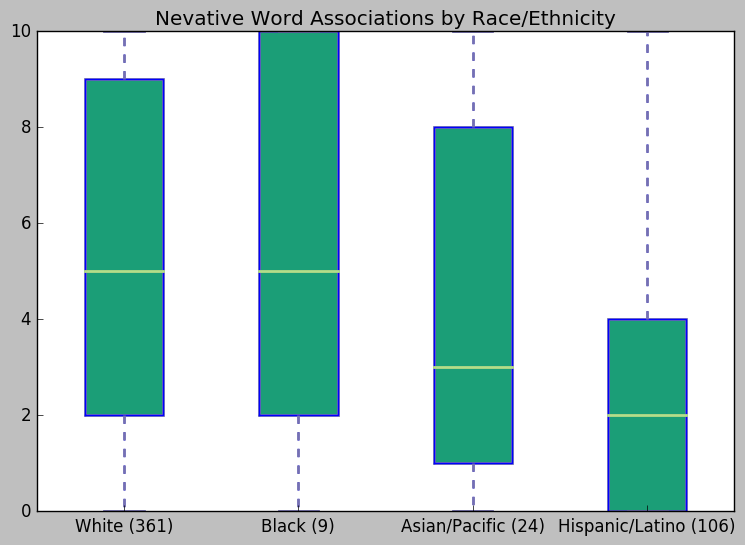

In [64]:
# Save the figure
fig2.savefig('fig2.png', bbox_inches='tight')
plt.show()

### Step 8 Create Multiple Radar Charts
We have now successfully visualized the aggregate data for each race, but we still need to see how the negative word associations are broken down by criterion. To do this, we will use radar charts.

The radar charts require us to arrange the data into a pandas data frame.

In [65]:
# Arrange data into data frame
df = pd.DataFrame({
'group': ['White ('+str(name_counts[0]) + ')', 'Black ('+str(name_counts[1]) + ')', 'Asian/Pacific ('+str(name_counts[2]) + ')', 'Hispanic/Latino ('+str(name_counts[3]) + ')'],
'arrest': [pctwhite_avg['arrest'], pctblack_avg['arrest'], pctapi_avg['arrest'], pcthispanic_avg['arrest']],
'murder': [pctwhite_avg['murder'], pctblack_avg['murder'], pctapi_avg['murder'], pcthispanic_avg['murder']],
'homicide': [pctwhite_avg['homicide'], pctblack_avg['homicide'], pctapi_avg['homicide'], pcthispanic_avg['homicide']],
'crime': [pctwhite_avg['crime'], pctblack_avg['crime'], pctapi_avg['crime'], pcthispanic_avg['crime']],
'prison': [pctwhite_avg['prison'], pctblack_avg['prison'], pctapi_avg['prison'], pcthispanic_avg['prison']]
})


Now we isolate the categories that include the data from the heading category.

In [66]:
# Separate variables from heading
categories=list(df)[:2]
categories+=list(df)[3:]
N = len(categories) #Number of variables

We now create a function to plot the data into four distinct radar charts. 

This function is adapted from https://python-graph-gallery.com/392-use-faceting-for-radar-chart/

In [67]:
def make_spider(row, title, color):
     
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )
     
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
     
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
     
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([2,4,6,8], ["2","4","6","8"], color="grey", size=7)
    plt.ylim(0,10)
     
    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
     
    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

Next we initialize the figure and run the function once for each racial/ethnic category.

Creating a color palette makes sure the function uses a different color for each chart.

In [68]:
# initialize the figure
my_dpi=300
fig3 = plt.figure(figsize=(3000/my_dpi, 3300/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title=df['group'][row], color=my_palette(row))

Now we can save figure three and show it.

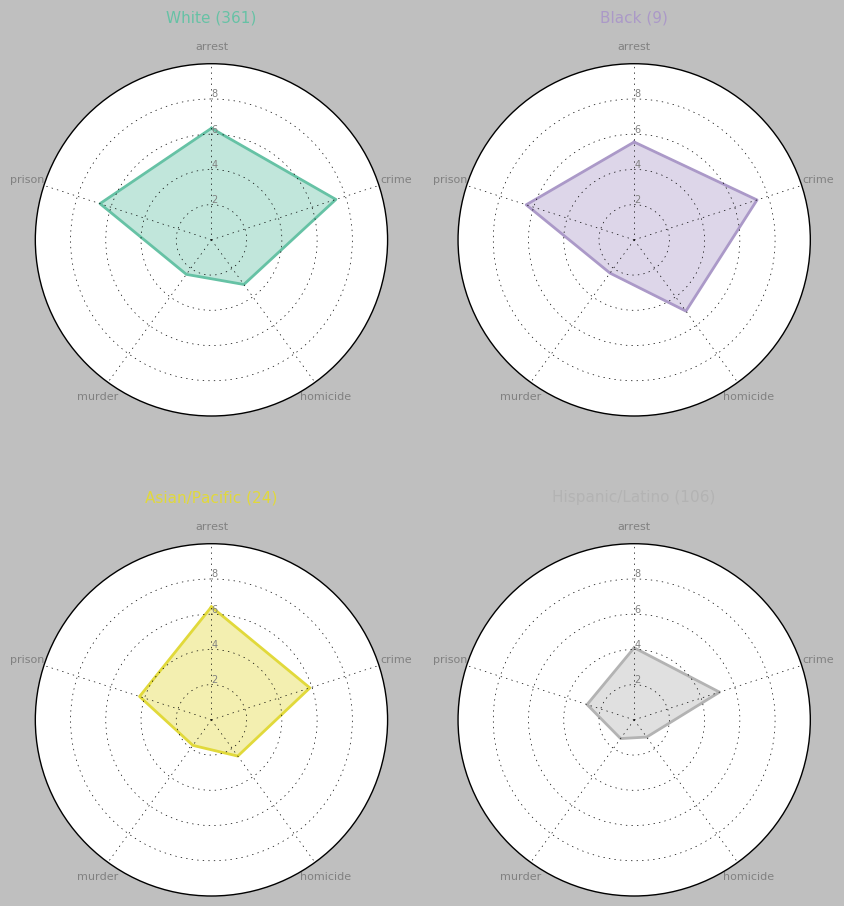

In [69]:
fig3.savefig('fig3.png', bbox_inches='tight')
plt.show()

### Step 9 Create Joint Radar Chart for comparison
To help the viewer compare the data, we will plot the same data on one chart.

This chart is adapted from https://python-graph-gallery.com/391-radar-chart-with-several-individuals/

First, we set up the lables, angles, and axes.

In [70]:
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([2,4,6,8], ["2","4","6","8"], color="grey", size=7)
plt.ylim(0,10)

(0, 10)

We now add plots for each color in the same color palette as before.

In [71]:
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

my_palette = plt.cm.get_cmap("Set2", len(df.index))
    
for i in range(0,len(df.index)):
    values=df.loc[i].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=my_palette(i), linewidth=1, linestyle='solid', label="group A")
    ax.fill(angles, values, color=my_palette(i), alpha=0.1)

Now we are ready to save and show figure 4.

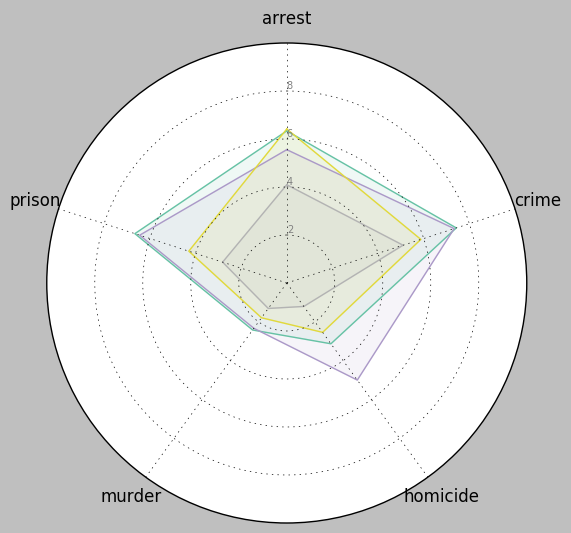

In [72]:
plt.savefig('fig4.png')
plt.show()

And now we have extracted, organized, summarized, written out, analyzed and visualized the data. Please find a discussion of our results in the proceedings of Use Cases in Big Data Software and Analyltics: https://cloudmesh.github.io/classes/